In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchinfo import summary # with torchsummary we got a bug, consider installing torchinfo
from torch.utils.data import DataLoader, TensorDataset # lets us load data in batches
from tqdm.notebook import tqdm # with tqdm we got a bug

In [2]:
# wget the file from https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
with open("shakespeare.txt") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
    
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 1115394 characters


In [3]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 65 unique characters.


In [4]:
print(decoding)
print(encoding)

{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i', 48: 'j', 49: 'k', 50: 'l', 51: 'm', 52: 'n', 53: 'o', 54: 'p', 55: 'q', 56: 'r', 57: 's', 58: 't', 59: 'u', 60: 'v', 61: 'w', 62: 'x', 63: 'y', 64: 'z'}
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47,

## Many to One  approach

In [5]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 20
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 1115374 sentences of length 20


In [6]:
print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56]
['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r']
e


In [7]:
# One-hot encode the data.
X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
y = torch.tensor(y_data) #No need to encode labels in one-hot with pytorch,
                         #crossEntropy loss needs just the indexes (not 0-1 values)


# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.size(), sentence_length))

Sanity check y. Dimension: torch.Size([1115374]) # Sentences: 1115374 Characters in corpus: 65
Sanity check X. Dimension: torch.Size([1115374, 20, 65]) Sentence length: 20


In [8]:
# Let's define our model
        
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        
        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size
        
        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1]
        # Convert the final state to our desired output shape (batch_size, output_size)
        out = self.fc(out)
        
        return out
    

In [9]:
hidden_size = 256
seq_length = 20
num_classes = 65
layer_size = 1
batch_size= 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(num_classes, hidden_size, layer_size, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, seq_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 --                        --
├─RNN: 1-1                               [128, 20, 256]            82,688
├─Linear: 1-2                            [128, 65]                 16,705
Total params: 99,393
Trainable params: 99,393
Non-trainable params: 0
Total mult-adds (M): 213.82
Input size (MB): 0.67
Forward/backward pass size (MB): 5.31
Params size (MB): 0.40
Estimated Total Size (MB): 6.37

In [10]:
model

RNNModel(
  (rnn): RNN(65, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=65, bias=True)
)

In [11]:
def train(epoch, model, data_loader, log_interval=200):
    model.train()
    total_train_loss = 0
    total_correct = 0 
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() 
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate. Updates the gradients buffer on each parameter
        loss.backward()
        # Update weights
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)

        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)

    
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [12]:
@torch.inference_mode() 
def predict(model, data):
    # Put the model in eval mode, which disables training specific behaviour.
    model.eval()
    output = model(data)
    return output

In [13]:
# Create dataloader from X,y tensors
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [14]:
# train the model
#%%time

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    

Training Epoch 1:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 1 [0/1115374 (0%)]	Loss: 4.169981
Train Epoch: 1 [25600/1115374 (2%)]	Loss: 2.681995
Train Epoch: 1 [51200/1115374 (5%)]	Loss: 2.469980
Train Epoch: 1 [76800/1115374 (7%)]	Loss: 2.224135
Train Epoch: 1 [102400/1115374 (9%)]	Loss: 2.281017
Train Epoch: 1 [128000/1115374 (11%)]	Loss: 2.175488
Train Epoch: 1 [153600/1115374 (14%)]	Loss: 2.363190
Train Epoch: 1 [179200/1115374 (16%)]	Loss: 2.362417
Train Epoch: 1 [204800/1115374 (18%)]	Loss: 2.395211
Train Epoch: 1 [230400/1115374 (21%)]	Loss: 2.076811
Train Epoch: 1 [256000/1115374 (23%)]	Loss: 2.212866
Train Epoch: 1 [281600/1115374 (25%)]	Loss: 1.969840
Train Epoch: 1 [307200/1115374 (28%)]	Loss: 2.132294
Train Epoch: 1 [332800/1115374 (30%)]	Loss: 2.136962
Train Epoch: 1 [358400/1115374 (32%)]	Loss: 2.033324
Train Epoch: 1 [384000/1115374 (34%)]	Loss: 2.021786
Train Epoch: 1 [409600/1115374 (37%)]	Loss: 1.968149
Train Epoch: 1 [435200/1115374 (39%)]	Loss: 2.089594
Train Epoch: 1 [460800/1115374 (41%)]	Loss: 1.896635
Train 

Training Epoch 2:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 2 [0/1115374 (0%)]	Loss: 1.893206
Train Epoch: 2 [25600/1115374 (2%)]	Loss: 1.747950
Train Epoch: 2 [51200/1115374 (5%)]	Loss: 1.497042
Train Epoch: 2 [76800/1115374 (7%)]	Loss: 1.979671
Train Epoch: 2 [102400/1115374 (9%)]	Loss: 1.838284
Train Epoch: 2 [128000/1115374 (11%)]	Loss: 1.733971
Train Epoch: 2 [153600/1115374 (14%)]	Loss: 1.942205
Train Epoch: 2 [179200/1115374 (16%)]	Loss: 1.814615
Train Epoch: 2 [204800/1115374 (18%)]	Loss: 1.849527
Train Epoch: 2 [230400/1115374 (21%)]	Loss: 1.844924
Train Epoch: 2 [256000/1115374 (23%)]	Loss: 1.859700
Train Epoch: 2 [281600/1115374 (25%)]	Loss: 1.633758
Train Epoch: 2 [307200/1115374 (28%)]	Loss: 1.789626
Train Epoch: 2 [332800/1115374 (30%)]	Loss: 1.494280
Train Epoch: 2 [358400/1115374 (32%)]	Loss: 1.745963
Train Epoch: 2 [384000/1115374 (34%)]	Loss: 1.589289
Train Epoch: 2 [409600/1115374 (37%)]	Loss: 1.610713
Train Epoch: 2 [435200/1115374 (39%)]	Loss: 1.664986
Train Epoch: 2 [460800/1115374 (41%)]	Loss: 1.988114
Train 

Training Epoch 3:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 3 [0/1115374 (0%)]	Loss: 1.664692
Train Epoch: 3 [25600/1115374 (2%)]	Loss: 1.620970
Train Epoch: 3 [51200/1115374 (5%)]	Loss: 1.690218
Train Epoch: 3 [76800/1115374 (7%)]	Loss: 1.650244
Train Epoch: 3 [102400/1115374 (9%)]	Loss: 1.873940
Train Epoch: 3 [128000/1115374 (11%)]	Loss: 1.581694
Train Epoch: 3 [153600/1115374 (14%)]	Loss: 1.954471
Train Epoch: 3 [179200/1115374 (16%)]	Loss: 1.527580
Train Epoch: 3 [204800/1115374 (18%)]	Loss: 1.455660
Train Epoch: 3 [230400/1115374 (21%)]	Loss: 1.352105
Train Epoch: 3 [256000/1115374 (23%)]	Loss: 1.701287
Train Epoch: 3 [281600/1115374 (25%)]	Loss: 1.623415
Train Epoch: 3 [307200/1115374 (28%)]	Loss: 1.420686
Train Epoch: 3 [332800/1115374 (30%)]	Loss: 1.723725
Train Epoch: 3 [358400/1115374 (32%)]	Loss: 1.722481
Train Epoch: 3 [384000/1115374 (34%)]	Loss: 1.655469
Train Epoch: 3 [409600/1115374 (37%)]	Loss: 1.813828
Train Epoch: 3 [435200/1115374 (39%)]	Loss: 1.791356
Train Epoch: 3 [460800/1115374 (41%)]	Loss: 1.711065
Train 

Training Epoch 4:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 4 [0/1115374 (0%)]	Loss: 1.628476
Train Epoch: 4 [25600/1115374 (2%)]	Loss: 1.673342
Train Epoch: 4 [51200/1115374 (5%)]	Loss: 1.568448
Train Epoch: 4 [76800/1115374 (7%)]	Loss: 1.698754
Train Epoch: 4 [102400/1115374 (9%)]	Loss: 1.625651
Train Epoch: 4 [128000/1115374 (11%)]	Loss: 1.331128
Train Epoch: 4 [153600/1115374 (14%)]	Loss: 1.626625
Train Epoch: 4 [179200/1115374 (16%)]	Loss: 1.477084
Train Epoch: 4 [204800/1115374 (18%)]	Loss: 1.515971
Train Epoch: 4 [230400/1115374 (21%)]	Loss: 1.538875
Train Epoch: 4 [256000/1115374 (23%)]	Loss: 1.710585
Train Epoch: 4 [281600/1115374 (25%)]	Loss: 1.845536
Train Epoch: 4 [307200/1115374 (28%)]	Loss: 1.615008
Train Epoch: 4 [332800/1115374 (30%)]	Loss: 1.522805
Train Epoch: 4 [358400/1115374 (32%)]	Loss: 1.484212
Train Epoch: 4 [384000/1115374 (34%)]	Loss: 1.633295
Train Epoch: 4 [409600/1115374 (37%)]	Loss: 1.608667
Train Epoch: 4 [435200/1115374 (39%)]	Loss: 1.613888
Train Epoch: 4 [460800/1115374 (41%)]	Loss: 1.548276
Train 

Training Epoch 5:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 5 [0/1115374 (0%)]	Loss: 1.663267
Train Epoch: 5 [25600/1115374 (2%)]	Loss: 1.650827
Train Epoch: 5 [51200/1115374 (5%)]	Loss: 1.562723
Train Epoch: 5 [76800/1115374 (7%)]	Loss: 1.387399
Train Epoch: 5 [102400/1115374 (9%)]	Loss: 1.441072
Train Epoch: 5 [128000/1115374 (11%)]	Loss: 1.544817
Train Epoch: 5 [153600/1115374 (14%)]	Loss: 1.618398
Train Epoch: 5 [179200/1115374 (16%)]	Loss: 1.633166
Train Epoch: 5 [204800/1115374 (18%)]	Loss: 1.547117
Train Epoch: 5 [230400/1115374 (21%)]	Loss: 1.344917
Train Epoch: 5 [256000/1115374 (23%)]	Loss: 1.581954
Train Epoch: 5 [281600/1115374 (25%)]	Loss: 1.401630
Train Epoch: 5 [307200/1115374 (28%)]	Loss: 1.600782
Train Epoch: 5 [332800/1115374 (30%)]	Loss: 1.544958
Train Epoch: 5 [358400/1115374 (32%)]	Loss: 1.439140
Train Epoch: 5 [384000/1115374 (34%)]	Loss: 1.718422
Train Epoch: 5 [409600/1115374 (37%)]	Loss: 1.454385
Train Epoch: 5 [435200/1115374 (39%)]	Loss: 1.528686
Train Epoch: 5 [460800/1115374 (41%)]	Loss: 1.473672
Train 

Training Epoch 6:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 6 [0/1115374 (0%)]	Loss: 1.455825
Train Epoch: 6 [25600/1115374 (2%)]	Loss: 1.395231
Train Epoch: 6 [51200/1115374 (5%)]	Loss: 1.348149
Train Epoch: 6 [76800/1115374 (7%)]	Loss: 1.412148
Train Epoch: 6 [102400/1115374 (9%)]	Loss: 1.817682
Train Epoch: 6 [128000/1115374 (11%)]	Loss: 1.650083
Train Epoch: 6 [153600/1115374 (14%)]	Loss: 1.443524
Train Epoch: 6 [179200/1115374 (16%)]	Loss: 1.637295
Train Epoch: 6 [204800/1115374 (18%)]	Loss: 1.591505
Train Epoch: 6 [230400/1115374 (21%)]	Loss: 1.694021
Train Epoch: 6 [256000/1115374 (23%)]	Loss: 1.263211
Train Epoch: 6 [281600/1115374 (25%)]	Loss: 1.528619
Train Epoch: 6 [307200/1115374 (28%)]	Loss: 1.524690
Train Epoch: 6 [332800/1115374 (30%)]	Loss: 1.651365
Train Epoch: 6 [358400/1115374 (32%)]	Loss: 1.541546
Train Epoch: 6 [384000/1115374 (34%)]	Loss: 1.527930
Train Epoch: 6 [409600/1115374 (37%)]	Loss: 1.744090
Train Epoch: 6 [435200/1115374 (39%)]	Loss: 1.608756
Train Epoch: 6 [460800/1115374 (41%)]	Loss: 1.453132
Train 

Training Epoch 7:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 7 [0/1115374 (0%)]	Loss: 1.572369
Train Epoch: 7 [25600/1115374 (2%)]	Loss: 1.613103
Train Epoch: 7 [51200/1115374 (5%)]	Loss: 1.539670
Train Epoch: 7 [76800/1115374 (7%)]	Loss: 1.491674
Train Epoch: 7 [102400/1115374 (9%)]	Loss: 1.763354
Train Epoch: 7 [128000/1115374 (11%)]	Loss: 1.569413
Train Epoch: 7 [153600/1115374 (14%)]	Loss: 1.507401
Train Epoch: 7 [179200/1115374 (16%)]	Loss: 1.882342
Train Epoch: 7 [204800/1115374 (18%)]	Loss: 1.611797
Train Epoch: 7 [230400/1115374 (21%)]	Loss: 1.535619
Train Epoch: 7 [256000/1115374 (23%)]	Loss: 1.783667
Train Epoch: 7 [281600/1115374 (25%)]	Loss: 1.491929
Train Epoch: 7 [307200/1115374 (28%)]	Loss: 1.543199
Train Epoch: 7 [332800/1115374 (30%)]	Loss: 1.481814
Train Epoch: 7 [358400/1115374 (32%)]	Loss: 1.387993
Train Epoch: 7 [384000/1115374 (34%)]	Loss: 1.532188
Train Epoch: 7 [409600/1115374 (37%)]	Loss: 1.467701
Train Epoch: 7 [435200/1115374 (39%)]	Loss: 1.737835
Train Epoch: 7 [460800/1115374 (41%)]	Loss: 1.487697
Train 

Training Epoch 8:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 8 [0/1115374 (0%)]	Loss: 1.394031
Train Epoch: 8 [25600/1115374 (2%)]	Loss: 1.722870
Train Epoch: 8 [51200/1115374 (5%)]	Loss: 1.519711
Train Epoch: 8 [76800/1115374 (7%)]	Loss: 1.510985
Train Epoch: 8 [102400/1115374 (9%)]	Loss: 1.671777
Train Epoch: 8 [128000/1115374 (11%)]	Loss: 1.394284
Train Epoch: 8 [153600/1115374 (14%)]	Loss: 1.642728
Train Epoch: 8 [179200/1115374 (16%)]	Loss: 1.483497
Train Epoch: 8 [204800/1115374 (18%)]	Loss: 1.613371
Train Epoch: 8 [230400/1115374 (21%)]	Loss: 1.621354
Train Epoch: 8 [256000/1115374 (23%)]	Loss: 1.532810
Train Epoch: 8 [281600/1115374 (25%)]	Loss: 1.464196
Train Epoch: 8 [307200/1115374 (28%)]	Loss: 1.557190
Train Epoch: 8 [332800/1115374 (30%)]	Loss: 1.382360
Train Epoch: 8 [358400/1115374 (32%)]	Loss: 1.326828
Train Epoch: 8 [384000/1115374 (34%)]	Loss: 1.661571
Train Epoch: 8 [409600/1115374 (37%)]	Loss: 1.444420
Train Epoch: 8 [435200/1115374 (39%)]	Loss: 1.512709
Train Epoch: 8 [460800/1115374 (41%)]	Loss: 1.585636
Train 

Training Epoch 9:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 9 [0/1115374 (0%)]	Loss: 1.247814
Train Epoch: 9 [25600/1115374 (2%)]	Loss: 1.563518
Train Epoch: 9 [51200/1115374 (5%)]	Loss: 1.745325
Train Epoch: 9 [76800/1115374 (7%)]	Loss: 1.704841
Train Epoch: 9 [102400/1115374 (9%)]	Loss: 1.519532
Train Epoch: 9 [128000/1115374 (11%)]	Loss: 1.779722
Train Epoch: 9 [153600/1115374 (14%)]	Loss: 1.397050
Train Epoch: 9 [179200/1115374 (16%)]	Loss: 1.787843
Train Epoch: 9 [204800/1115374 (18%)]	Loss: 1.517735
Train Epoch: 9 [230400/1115374 (21%)]	Loss: 1.417898
Train Epoch: 9 [256000/1115374 (23%)]	Loss: 1.627772
Train Epoch: 9 [281600/1115374 (25%)]	Loss: 1.350984
Train Epoch: 9 [307200/1115374 (28%)]	Loss: 1.609475
Train Epoch: 9 [332800/1115374 (30%)]	Loss: 1.429184
Train Epoch: 9 [358400/1115374 (32%)]	Loss: 1.351100
Train Epoch: 9 [384000/1115374 (34%)]	Loss: 1.430286
Train Epoch: 9 [409600/1115374 (37%)]	Loss: 1.433340
Train Epoch: 9 [435200/1115374 (39%)]	Loss: 1.766405
Train Epoch: 9 [460800/1115374 (41%)]	Loss: 1.514033
Train 

Training Epoch 10:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 10 [0/1115374 (0%)]	Loss: 1.633830
Train Epoch: 10 [25600/1115374 (2%)]	Loss: 1.504240
Train Epoch: 10 [51200/1115374 (5%)]	Loss: 1.612590
Train Epoch: 10 [76800/1115374 (7%)]	Loss: 1.515229
Train Epoch: 10 [102400/1115374 (9%)]	Loss: 1.343975
Train Epoch: 10 [128000/1115374 (11%)]	Loss: 1.854024
Train Epoch: 10 [153600/1115374 (14%)]	Loss: 1.419483
Train Epoch: 10 [179200/1115374 (16%)]	Loss: 1.478558
Train Epoch: 10 [204800/1115374 (18%)]	Loss: 1.545510
Train Epoch: 10 [230400/1115374 (21%)]	Loss: 1.596822
Train Epoch: 10 [256000/1115374 (23%)]	Loss: 1.465683
Train Epoch: 10 [281600/1115374 (25%)]	Loss: 1.738907
Train Epoch: 10 [307200/1115374 (28%)]	Loss: 1.496520
Train Epoch: 10 [332800/1115374 (30%)]	Loss: 1.562315
Train Epoch: 10 [358400/1115374 (32%)]	Loss: 1.580261
Train Epoch: 10 [384000/1115374 (34%)]	Loss: 1.424862
Train Epoch: 10 [409600/1115374 (37%)]	Loss: 1.244634
Train Epoch: 10 [435200/1115374 (39%)]	Loss: 1.789104
Train Epoch: 10 [460800/1115374 (41%)]	Lo

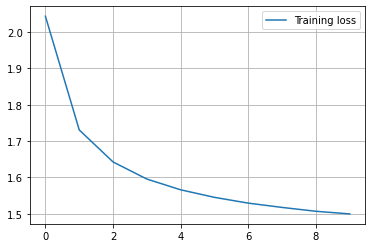

In [15]:
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.grid()

In [16]:
def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern
    
    

seed_pattern = make_seed("Once upon a time in ")
print("seed = " + seed_pattern)

encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float)
# Add a single batch dimension at the beginning
encoded_text = encoded_text.unsqueeze(0)
encoded_text = encoded_text.to(device)

generated_text = ""
for i in range(500):
    # predict() gives a tensor of shape (1, 65) 
    # with 1 being the size of the batch, for that we use [0] to get a vector
    output = predict(model, encoded_text)[0]
    # Convert the output to probabilities
    probs = torch.softmax(output, dim=-1)
    # Randomly choose from a multinomial distribution with the output probabilities
    # make the generation more diverse.
    prediction = torch.multinomial(probs, num_samples=1)
    generated_text += decoding[int(prediction)]
    
    # One hot encode the new (predicted) character
    next_char_encoded = F.one_hot(prediction, num_classes=num_chars)
    # Make sure it has a singular batch and seq_len dimension in order to concatenate them.
    next_char_encoded = next_char_encoded.view(1, 1, num_chars)
    # Remove first char and glue the predicted one to the end
    encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)
print(generated_text)

seed = Once upon a time in 
me than I am love port's as intopt,
Thy soul stay, us and gentle poor decext post that firsublo's sist mine!
Anch, Romer on thee, yet he knee
full true heir of moce to Richard.

POMPEY:
Now entent they so, my lord.

ROMEO:
Pay's hungling awaicother his quaints of man than
A find'd so let us appreice,
And father we was fell will -wompedly sifel king,
thou hath were is is his frath, or present and govisuim in minimable
And pleasare livine mear grievens for
thee.

LEONTES:
There's Couss'd, stay you


## Many to many approach

In [43]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 20
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i+1:i+1 + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append([encoding[char] for char in next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 1115374 sentences of length 20


In [44]:
print(X_data[0])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56]


In [45]:
print([decoding[idx] for idx in X_data[0]])
print([decoding[idx] for idx in y_data[0]])


['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r']
['i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r', 'e']


In [46]:
# One-hot encode the data.
X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
y = torch.tensor(y_data)

In [51]:
# many2many model
class mmRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        
        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size
        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        #out = out[:, -1] # as you can see this line was deleted: This means instead of taking just the last hidden
        #state with out = out[:, -1] (size: batch_size x num_classes), we keep all the hidden states because out has 
        #a size of: batch_size x seq_len x num_classes (one hidden state per character in the sequence).

        
        #During inference, we take only the last hidden state
        #because other predictions are used only to train the model
        if not self.train:
            out = out[:, -1]
            
        # the Linear layer works automatically with one more dimension.
        out = self.fc(out)
        
        return out

In [52]:
hidden_size = 256
seq_length = 20
num_classes = 65
layer_size = 1
batch_size= 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelmm = mmRNNModel(num_classes, hidden_size, layer_size, num_classes).to(device)
optimizer = torch.optim.Adam(modelmm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(modelmm, input_size=(batch_size, seq_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
mmRNNModel                               --                        --
├─RNN: 1-1                               [128, 20, 256]            82,688
├─Linear: 1-2                            [128, 20, 65]             16,705
Total params: 99,393
Trainable params: 99,393
Non-trainable params: 0
Total mult-adds (M): 213.82
Input size (MB): 0.67
Forward/backward pass size (MB): 6.57
Params size (MB): 0.40
Estimated Total Size (MB): 7.64

In [53]:
def train(epoch, model, data_loader, log_interval=200):
    model.train()
    total_train_loss = 0
    total_correct = 0 
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() 

        output = model(data)
        
        #the only modification here consists in modifying the cross-entropy, because it takes inputs with 
        #dimensions: (N, C, d1, d2, ..., dk), that means the dimension of the classes is always the 2nd, 
        #and all the extra dimensions come at the end. You have to change your output to size:
        # batch_size x seq_len x num_classes -> batch_size x num_classes x seq_len. 
        #It's just a transpose of the loss criterion (output.transpose(1, 2), target).
        output = output.transpose(1, 2) 
        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)

        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)

    
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [59]:
@torch.inference_mode() 
def predict(model, data):
    # Put the model in eval mode
    model.eval()
    output = model(data)
    return output

In [55]:
# Create dataloader from X,y tensors
datasett = TensorDataset(X, y)
train_loader = DataLoader(datasett, batch_size=batch_size, shuffle=True)

Training Epoch 1:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 1 [0/1115374 (0%)]	Loss: 4.172177
Train Epoch: 1 [25600/1115374 (2%)]	Loss: 2.544350
Train Epoch: 1 [51200/1115374 (5%)]	Loss: 2.233426
Train Epoch: 1 [76800/1115374 (7%)]	Loss: 2.088389
Train Epoch: 1 [102400/1115374 (9%)]	Loss: 2.093889
Train Epoch: 1 [128000/1115374 (11%)]	Loss: 2.030957
Train Epoch: 1 [153600/1115374 (14%)]	Loss: 1.971463
Train Epoch: 1 [179200/1115374 (16%)]	Loss: 1.950469
Train Epoch: 1 [204800/1115374 (18%)]	Loss: 1.923469
Train Epoch: 1 [230400/1115374 (21%)]	Loss: 1.884498
Train Epoch: 1 [256000/1115374 (23%)]	Loss: 1.864313
Train Epoch: 1 [281600/1115374 (25%)]	Loss: 1.828224
Train Epoch: 1 [307200/1115374 (28%)]	Loss: 1.817915
Train Epoch: 1 [332800/1115374 (30%)]	Loss: 1.736223
Train Epoch: 1 [358400/1115374 (32%)]	Loss: 1.711920
Train Epoch: 1 [384000/1115374 (34%)]	Loss: 1.743092
Train Epoch: 1 [409600/1115374 (37%)]	Loss: 1.754062
Train Epoch: 1 [435200/1115374 (39%)]	Loss: 1.767477
Train Epoch: 1 [460800/1115374 (41%)]	Loss: 1.722563
Train 

Training Epoch 2:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 2 [0/1115374 (0%)]	Loss: 1.536698
Train Epoch: 2 [25600/1115374 (2%)]	Loss: 1.569369
Train Epoch: 2 [51200/1115374 (5%)]	Loss: 1.588265
Train Epoch: 2 [76800/1115374 (7%)]	Loss: 1.587728
Train Epoch: 2 [102400/1115374 (9%)]	Loss: 1.563061
Train Epoch: 2 [128000/1115374 (11%)]	Loss: 1.554513
Train Epoch: 2 [153600/1115374 (14%)]	Loss: 1.564109
Train Epoch: 2 [179200/1115374 (16%)]	Loss: 1.569998
Train Epoch: 2 [204800/1115374 (18%)]	Loss: 1.608607
Train Epoch: 2 [230400/1115374 (21%)]	Loss: 1.558463
Train Epoch: 2 [256000/1115374 (23%)]	Loss: 1.547767
Train Epoch: 2 [281600/1115374 (25%)]	Loss: 1.553298
Train Epoch: 2 [307200/1115374 (28%)]	Loss: 1.517699
Train Epoch: 2 [332800/1115374 (30%)]	Loss: 1.587879
Train Epoch: 2 [358400/1115374 (32%)]	Loss: 1.592025
Train Epoch: 2 [384000/1115374 (34%)]	Loss: 1.552779
Train Epoch: 2 [409600/1115374 (37%)]	Loss: 1.541762
Train Epoch: 2 [435200/1115374 (39%)]	Loss: 1.551604
Train Epoch: 2 [460800/1115374 (41%)]	Loss: 1.579680
Train 

Training Epoch 3:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 3 [0/1115374 (0%)]	Loss: 1.539454
Train Epoch: 3 [25600/1115374 (2%)]	Loss: 1.504982
Train Epoch: 3 [51200/1115374 (5%)]	Loss: 1.529754
Train Epoch: 3 [76800/1115374 (7%)]	Loss: 1.518779
Train Epoch: 3 [102400/1115374 (9%)]	Loss: 1.512467
Train Epoch: 3 [128000/1115374 (11%)]	Loss: 1.484903
Train Epoch: 3 [153600/1115374 (14%)]	Loss: 1.470957
Train Epoch: 3 [179200/1115374 (16%)]	Loss: 1.526166
Train Epoch: 3 [204800/1115374 (18%)]	Loss: 1.515310
Train Epoch: 3 [230400/1115374 (21%)]	Loss: 1.527707
Train Epoch: 3 [256000/1115374 (23%)]	Loss: 1.516012
Train Epoch: 3 [281600/1115374 (25%)]	Loss: 1.533146
Train Epoch: 3 [307200/1115374 (28%)]	Loss: 1.525366
Train Epoch: 3 [332800/1115374 (30%)]	Loss: 1.495656
Train Epoch: 3 [358400/1115374 (32%)]	Loss: 1.561352
Train Epoch: 3 [384000/1115374 (34%)]	Loss: 1.526683
Train Epoch: 3 [409600/1115374 (37%)]	Loss: 1.531038
Train Epoch: 3 [435200/1115374 (39%)]	Loss: 1.534438
Train Epoch: 3 [460800/1115374 (41%)]	Loss: 1.498658
Train 

Training Epoch 4:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 4 [0/1115374 (0%)]	Loss: 1.509487
Train Epoch: 4 [25600/1115374 (2%)]	Loss: 1.458155
Train Epoch: 4 [51200/1115374 (5%)]	Loss: 1.523409
Train Epoch: 4 [76800/1115374 (7%)]	Loss: 1.476128
Train Epoch: 4 [102400/1115374 (9%)]	Loss: 1.466203
Train Epoch: 4 [128000/1115374 (11%)]	Loss: 1.473978
Train Epoch: 4 [153600/1115374 (14%)]	Loss: 1.531862
Train Epoch: 4 [179200/1115374 (16%)]	Loss: 1.470111
Train Epoch: 4 [204800/1115374 (18%)]	Loss: 1.447136
Train Epoch: 4 [230400/1115374 (21%)]	Loss: 1.481505
Train Epoch: 4 [256000/1115374 (23%)]	Loss: 1.501323
Train Epoch: 4 [281600/1115374 (25%)]	Loss: 1.530830
Train Epoch: 4 [307200/1115374 (28%)]	Loss: 1.525326
Train Epoch: 4 [332800/1115374 (30%)]	Loss: 1.508922
Train Epoch: 4 [358400/1115374 (32%)]	Loss: 1.518891
Train Epoch: 4 [384000/1115374 (34%)]	Loss: 1.500841
Train Epoch: 4 [409600/1115374 (37%)]	Loss: 1.539945
Train Epoch: 4 [435200/1115374 (39%)]	Loss: 1.486008
Train Epoch: 4 [460800/1115374 (41%)]	Loss: 1.498008
Train 

Training Epoch 5:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 5 [0/1115374 (0%)]	Loss: 1.396901
Train Epoch: 5 [25600/1115374 (2%)]	Loss: 1.472029
Train Epoch: 5 [51200/1115374 (5%)]	Loss: 1.564534
Train Epoch: 5 [76800/1115374 (7%)]	Loss: 1.464843
Train Epoch: 5 [102400/1115374 (9%)]	Loss: 1.471632
Train Epoch: 5 [128000/1115374 (11%)]	Loss: 1.447609
Train Epoch: 5 [153600/1115374 (14%)]	Loss: 1.465453
Train Epoch: 5 [179200/1115374 (16%)]	Loss: 1.504221
Train Epoch: 5 [204800/1115374 (18%)]	Loss: 1.491246
Train Epoch: 5 [230400/1115374 (21%)]	Loss: 1.449474
Train Epoch: 5 [256000/1115374 (23%)]	Loss: 1.462004
Train Epoch: 5 [281600/1115374 (25%)]	Loss: 1.463349
Train Epoch: 5 [307200/1115374 (28%)]	Loss: 1.461627
Train Epoch: 5 [332800/1115374 (30%)]	Loss: 1.502609
Train Epoch: 5 [358400/1115374 (32%)]	Loss: 1.510509
Train Epoch: 5 [384000/1115374 (34%)]	Loss: 1.460523
Train Epoch: 5 [409600/1115374 (37%)]	Loss: 1.463245
Train Epoch: 5 [435200/1115374 (39%)]	Loss: 1.479582
Train Epoch: 5 [460800/1115374 (41%)]	Loss: 1.491033
Train 

Training Epoch 6:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 6 [0/1115374 (0%)]	Loss: 1.477747
Train Epoch: 6 [25600/1115374 (2%)]	Loss: 1.495365
Train Epoch: 6 [51200/1115374 (5%)]	Loss: 1.442849
Train Epoch: 6 [76800/1115374 (7%)]	Loss: 1.472844
Train Epoch: 6 [102400/1115374 (9%)]	Loss: 1.455407
Train Epoch: 6 [128000/1115374 (11%)]	Loss: 1.513244
Train Epoch: 6 [153600/1115374 (14%)]	Loss: 1.474970
Train Epoch: 6 [179200/1115374 (16%)]	Loss: 1.447728
Train Epoch: 6 [204800/1115374 (18%)]	Loss: 1.443928
Train Epoch: 6 [230400/1115374 (21%)]	Loss: 1.488297
Train Epoch: 6 [256000/1115374 (23%)]	Loss: 1.417107
Train Epoch: 6 [281600/1115374 (25%)]	Loss: 1.464979
Train Epoch: 6 [307200/1115374 (28%)]	Loss: 1.517345
Train Epoch: 6 [332800/1115374 (30%)]	Loss: 1.466341
Train Epoch: 6 [358400/1115374 (32%)]	Loss: 1.452345
Train Epoch: 6 [384000/1115374 (34%)]	Loss: 1.479474
Train Epoch: 6 [409600/1115374 (37%)]	Loss: 1.489272
Train Epoch: 6 [435200/1115374 (39%)]	Loss: 1.517976
Train Epoch: 6 [460800/1115374 (41%)]	Loss: 1.453275
Train 

Training Epoch 7:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 7 [0/1115374 (0%)]	Loss: 1.458042
Train Epoch: 7 [25600/1115374 (2%)]	Loss: 1.505295
Train Epoch: 7 [51200/1115374 (5%)]	Loss: 1.487973
Train Epoch: 7 [76800/1115374 (7%)]	Loss: 1.450532
Train Epoch: 7 [102400/1115374 (9%)]	Loss: 1.519175
Train Epoch: 7 [128000/1115374 (11%)]	Loss: 1.447730
Train Epoch: 7 [153600/1115374 (14%)]	Loss: 1.385994
Train Epoch: 7 [179200/1115374 (16%)]	Loss: 1.455643
Train Epoch: 7 [204800/1115374 (18%)]	Loss: 1.431857
Train Epoch: 7 [230400/1115374 (21%)]	Loss: 1.508147
Train Epoch: 7 [256000/1115374 (23%)]	Loss: 1.490445
Train Epoch: 7 [281600/1115374 (25%)]	Loss: 1.458014
Train Epoch: 7 [307200/1115374 (28%)]	Loss: 1.456334
Train Epoch: 7 [332800/1115374 (30%)]	Loss: 1.439624
Train Epoch: 7 [358400/1115374 (32%)]	Loss: 1.438722
Train Epoch: 7 [384000/1115374 (34%)]	Loss: 1.507646
Train Epoch: 7 [409600/1115374 (37%)]	Loss: 1.516918
Train Epoch: 7 [435200/1115374 (39%)]	Loss: 1.486762
Train Epoch: 7 [460800/1115374 (41%)]	Loss: 1.422819
Train 

Training Epoch 8:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 8 [0/1115374 (0%)]	Loss: 1.501893
Train Epoch: 8 [25600/1115374 (2%)]	Loss: 1.496443
Train Epoch: 8 [51200/1115374 (5%)]	Loss: 1.450829
Train Epoch: 8 [76800/1115374 (7%)]	Loss: 1.478724
Train Epoch: 8 [102400/1115374 (9%)]	Loss: 1.395806
Train Epoch: 8 [128000/1115374 (11%)]	Loss: 1.430150
Train Epoch: 8 [153600/1115374 (14%)]	Loss: 1.437168
Train Epoch: 8 [179200/1115374 (16%)]	Loss: 1.479817
Train Epoch: 8 [204800/1115374 (18%)]	Loss: 1.469563
Train Epoch: 8 [230400/1115374 (21%)]	Loss: 1.448378
Train Epoch: 8 [256000/1115374 (23%)]	Loss: 1.436480
Train Epoch: 8 [281600/1115374 (25%)]	Loss: 1.424918
Train Epoch: 8 [307200/1115374 (28%)]	Loss: 1.464126
Train Epoch: 8 [332800/1115374 (30%)]	Loss: 1.479537
Train Epoch: 8 [358400/1115374 (32%)]	Loss: 1.473022
Train Epoch: 8 [384000/1115374 (34%)]	Loss: 1.481032
Train Epoch: 8 [409600/1115374 (37%)]	Loss: 1.422234
Train Epoch: 8 [435200/1115374 (39%)]	Loss: 1.468623
Train Epoch: 8 [460800/1115374 (41%)]	Loss: 1.452960
Train 

Training Epoch 9:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 9 [0/1115374 (0%)]	Loss: 1.413422
Train Epoch: 9 [25600/1115374 (2%)]	Loss: 1.488958
Train Epoch: 9 [51200/1115374 (5%)]	Loss: 1.499605
Train Epoch: 9 [76800/1115374 (7%)]	Loss: 1.484985
Train Epoch: 9 [102400/1115374 (9%)]	Loss: 1.448737
Train Epoch: 9 [128000/1115374 (11%)]	Loss: 1.461100
Train Epoch: 9 [153600/1115374 (14%)]	Loss: 1.419195
Train Epoch: 9 [179200/1115374 (16%)]	Loss: 1.469285
Train Epoch: 9 [204800/1115374 (18%)]	Loss: 1.456138
Train Epoch: 9 [230400/1115374 (21%)]	Loss: 1.452205
Train Epoch: 9 [256000/1115374 (23%)]	Loss: 1.426126
Train Epoch: 9 [281600/1115374 (25%)]	Loss: 1.420633
Train Epoch: 9 [307200/1115374 (28%)]	Loss: 1.471583
Train Epoch: 9 [332800/1115374 (30%)]	Loss: 1.476816
Train Epoch: 9 [358400/1115374 (32%)]	Loss: 1.497860
Train Epoch: 9 [384000/1115374 (34%)]	Loss: 1.518155
Train Epoch: 9 [409600/1115374 (37%)]	Loss: 1.450316
Train Epoch: 9 [435200/1115374 (39%)]	Loss: 1.466191
Train Epoch: 9 [460800/1115374 (41%)]	Loss: 1.479591
Train 

Training Epoch 10:   0%|          | 0/8714 [00:00<?, ?it/s]

Train Epoch: 10 [0/1115374 (0%)]	Loss: 1.434524
Train Epoch: 10 [25600/1115374 (2%)]	Loss: 1.475028
Train Epoch: 10 [51200/1115374 (5%)]	Loss: 1.410230
Train Epoch: 10 [76800/1115374 (7%)]	Loss: 1.415122
Train Epoch: 10 [102400/1115374 (9%)]	Loss: 1.391300
Train Epoch: 10 [128000/1115374 (11%)]	Loss: 1.477898
Train Epoch: 10 [153600/1115374 (14%)]	Loss: 1.475510
Train Epoch: 10 [179200/1115374 (16%)]	Loss: 1.444108
Train Epoch: 10 [204800/1115374 (18%)]	Loss: 1.461217
Train Epoch: 10 [230400/1115374 (21%)]	Loss: 1.455505
Train Epoch: 10 [256000/1115374 (23%)]	Loss: 1.439392
Train Epoch: 10 [281600/1115374 (25%)]	Loss: 1.430392
Train Epoch: 10 [307200/1115374 (28%)]	Loss: 1.508476
Train Epoch: 10 [332800/1115374 (30%)]	Loss: 1.406947
Train Epoch: 10 [358400/1115374 (32%)]	Loss: 1.451527
Train Epoch: 10 [384000/1115374 (34%)]	Loss: 1.459649
Train Epoch: 10 [409600/1115374 (37%)]	Loss: 1.451418
Train Epoch: 10 [435200/1115374 (39%)]	Loss: 1.448162
Train Epoch: 10 [460800/1115374 (41%)]	Lo

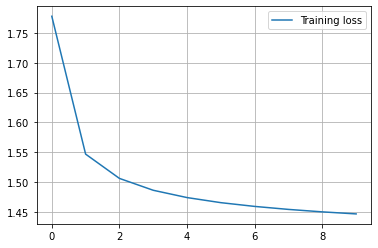

In [56]:
# train the model
# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    train_result = train(epoch, modelmm, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    

plt.plot(train_losses, label='Training loss')
plt.legend()
plt.grid()

In [133]:
def make_seed(seed_phrase=""):
        if seed_phrase:  
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern

seed_pattern = make_seed("In the early morning, the flower is shining")

# To Do as an optimization: add function here that takes as parameters the seed_pattern and the model

encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float)
# Add a single batch dimension at the beginning
encoded_text = encoded_text.unsqueeze(0)
encoded_text = encoded_text.to(device)
torch.manual_seed(42)
generated_text = ""
for i in range(500):
    output = predict(modelmm, encoded_text)[0]
    # Convert the output to probabilities
    probs = torch.softmax(output[-1], dim=-1)
    # make the generation more diverse.
    prediction = torch.multinomial(probs, num_samples=1)

    generated_text += decoding[int(prediction)]
    # One hot encode the new (predicted) character
    next_char_encoded = F.one_hot(prediction, num_classes=num_chars)
    # Make sure it has a singular batch and seq_len dimension in order to concatenate them.
    next_char_encoded = next_char_encoded.view(1, 1, num_chars)
    # Remove first char and glue the predicted one to the end
    encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)
print(generated_text)

 is loud and first, for ever do spoke and some purson in man go divito cqure of the maid the nupheling the Tiren
Herefor fame!
He'll at need flesh:
I though an own shep
him not hear, though it have becomes hide?
Think your holy her;
We was a crow: I did kiss and were course?
Doou may I spoke anot bring. Come, fair 'nighter'd him.

PROSPERO:
I will this how you,
When tributy,--Sound, conded at the birn's reasour expeach,
Though now to juit twice done a man, both duke
I saw bring he succe,
Her hav
